In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
# ============================================================
# 0) LOCK THE VARIABLES
# ============================================================

# Load data
df = pd.read_csv('../data/cleaned_metu_ring.csv')

# Define problem columns
problem_cols = [col for col in df.columns if col.startswith('Problem_')]
print(f"Found {len(problem_cols)} problem columns:")
print(problem_cols)

# Define satisfaction outcomes
satisfaction_cols = {
    'Weekend': 'Weekend_Schedule_Satisfaction',
    'Weekday': 'Weekday_Schedule_Satisfaction',
    'Overall': 'Overall_Satisfaction'
}

# Check which satisfaction columns exist
available_satisfaction = {k: v for k, v in satisfaction_cols.items() 
                        if v in df.columns}
print(f"\nAvailable satisfaction columns: {list(available_satisfaction.values())}")

# PRIMARY OUTCOME: Weekend satisfaction (as recommended)
primary_outcome = 'Weekend_Schedule_Satisfaction'
print(f"\nPrimary outcome: {primary_outcome}")

Found 8 problem columns:
['Problem_LateBus', 'Problem_TooCrowded', 'Problem_LongWait', 'Problem_NotMyRoute', 'Problem_RouteConfusing', 'Problem_HoursMismatch', 'Problem_NotClean', 'Problem_DriverBehavior']

Available satisfaction columns: ['Weekend_Schedule_Satisfaction', 'Weekday_Schedule_Satisfaction', 'Overall_Satisfaction']

Primary outcome: Weekend_Schedule_Satisfaction


In [4]:
# ============================================================
# ENCODE PROBLEM COLUMNS TO NUMERIC (1-5 scale)
# ============================================================

# Problem frequency mapping: Never=1, Rarely=2, Sometimes=3, Often=4, Always=5
problem_map = {
    'Never': 1,
    'Rarely': 2,
    'Sometimes': 3,
    'Often': 4,
    'Always': 5
}

# Check if columns are already numeric or need mapping
for col in problem_cols:
    if col in df.columns:
        if not pd.api.types.is_numeric_dtype(df[col]):
            # Map text to numeric
            df[col] = df[col].map(problem_map)
            print(f"✓ Mapped {col} to numeric (1-5 scale)")
        else:
            # Already numeric - verify it's 1-5 scale
            unique_vals = df[col].dropna().unique()
            if all(v in [1, 2, 3, 4, 5] for v in unique_vals):
                print(f"✓ {col} is already numeric (1-5 scale)")
            else:
                print(f"⚠ {col} is numeric but not 1-5 scale. Values: {sorted(unique_vals)}")
                # If it's 0-4, convert to 1-5
                if all(v in [0, 1, 2, 3, 4] for v in unique_vals):
                    df[col] = df[col] + 1
                    print(f"  → Converted 0-4 to 1-5 scale")

✓ Mapped Problem_LateBus to numeric (1-5 scale)
✓ Mapped Problem_TooCrowded to numeric (1-5 scale)
✓ Mapped Problem_LongWait to numeric (1-5 scale)
✓ Mapped Problem_NotMyRoute to numeric (1-5 scale)
✓ Mapped Problem_RouteConfusing to numeric (1-5 scale)
✓ Mapped Problem_HoursMismatch to numeric (1-5 scale)
✓ Mapped Problem_NotClean to numeric (1-5 scale)
✓ Mapped Problem_DriverBehavior to numeric (1-5 scale)


In [5]:
# ============================================================
# 1A) SPEARMAN CORRELATION ANALYSIS
# ============================================================

def compute_spearman_correlations(df, problem_cols, satisfaction_col):
    """
    Compute Spearman's rho for each problem vs satisfaction.
    Returns DataFrame with correlations, p-values, and rankings.
    """
    results = []
    
    for col in problem_cols:
        if col not in df.columns:
            continue
            
        # Get valid pairs (both non-null)
        valid_mask = df[[col, satisfaction_col]].notna().all(axis=1)
        problem_vals = df.loc[valid_mask, col]
        satisfaction_vals = df.loc[valid_mask, satisfaction_col]
        
        if len(problem_vals) < 3:  # Need at least 3 pairs
            continue
        
        # Compute Spearman correlation
        rho, p_value = stats.spearmanr(problem_vals, satisfaction_vals)
        
        # Problem name (clean)
        problem_name = col.replace('Problem_', '')
        
        results.append({
            'Problem': problem_name,
            'Spearman_rho': rho,
            'Abs_rho': abs(rho),
            'P_value': p_value,
            'N': len(problem_vals)
        })
    
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('Abs_rho', ascending=False)
    results_df['Rank'] = range(1, len(results_df) + 1)
    
    return results_df

# Compute correlations for primary outcome
correlation_results = compute_spearman_correlations(
    df, problem_cols, primary_outcome
)

print("=" * 70)
print("SPEARMAN CORRELATION RESULTS")
print("=" * 70)
print(correlation_results.to_string(index=False))
print("\nInterpretation:")
print(f"Problems are ranked by |Spearman's rho| (absolute correlation).")
print(f"Negative rho means higher problem frequency → lower satisfaction.")

SPEARMAN CORRELATION RESULTS
       Problem  Spearman_rho  Abs_rho      P_value   N  Rank
      LongWait     -0.288938 0.288938 1.143224e-07 325     1
    NotMyRoute     -0.165806 0.165806 2.714284e-03 325     2
    TooCrowded     -0.149611 0.149611 6.892557e-03 325     3
 HoursMismatch     -0.140581 0.140581 1.117383e-02 325     4
       LateBus     -0.134744 0.134744 1.506284e-02 325     5
      NotClean     -0.098427 0.098427 7.641259e-02 325     6
DriverBehavior     -0.091639 0.091639 9.911748e-02 325     7
RouteConfusing     -0.036398 0.036398 5.132010e-01 325     8

Interpretation:
Problems are ranked by |Spearman's rho| (absolute correlation).
Negative rho means higher problem frequency → lower satisfaction.


In [6]:
# ============================================================
# 1B) EFFECT SIZE ANALYSIS (Binary: Often/Always vs Not)
# ============================================================

def compute_effect_sizes(df, problem_cols, satisfaction_col):
    """
    For each problem, compare satisfaction between:
    - Often/Always (>=4) vs Not Often/Always (<4)
    
    Uses Mann-Whitney U test and computes effect sizes.
    """
    results = []
    
    for col in problem_cols:
        if col not in df.columns:
            continue
        
        # Create binary indicator: Often/Always = 1, else = 0
        # Note: Often=4, Always=5, so >=4 means Often/Always
        df_temp = df[[col, satisfaction_col]].copy()
        df_temp = df_temp.dropna()
        
        if len(df_temp) < 10:  # Need sufficient data
            continue
        
        # Binary indicator
        df_temp['Problem_Binary'] = (df_temp[col] >= 4).astype(int)
        
        # Split groups
        group_often_always = df_temp[df_temp['Problem_Binary'] == 1][satisfaction_col]
        group_not = df_temp[df_temp['Problem_Binary'] == 0][satisfaction_col]
        
        if len(group_often_always) < 3 or len(group_not) < 3:
            continue
        
        # Mann-Whitney U test
        statistic, p_value = mannwhitneyu(
            group_often_always, group_not, 
            alternative='two-sided'
        )
        
        # Effect size: Rank-biserial correlation
        # r = 1 - (2U / (n1 * n2))
        n1, n2 = len(group_often_always), len(group_not)
        U = min(statistic, n1 * n2 - statistic)  # Use smaller U
        rank_biserial = 1 - (2 * U / (n1 * n2))
        
        # Adjust sign: negative if Often/Always group has lower satisfaction
        if group_often_always.median() < group_not.median():
            rank_biserial = -abs(rank_biserial)
        else:
            rank_biserial = abs(rank_biserial)
        
        # Cliff's delta (alternative effect size)
        # δ = (P(X > Y) - P(X < Y))
        # Simplified approximation
        def cliffs_delta_approx(x, y):
            """Approximate Cliff's delta"""
            n_x, n_y = len(x), len(y)
            wins = sum(sum(xi > yj for yj in y) for xi in x)
            losses = sum(sum(xi < yj for yj in y) for xi in x)
            return (wins - losses) / (n_x * n_y)
        
        cliffs_d = cliffs_delta_approx(group_often_always.values, group_not.values)
        
        # Medians
        median_often_always = group_often_always.median()
        median_not = group_not.median()
        median_diff = median_often_always - median_not
        
        problem_name = col.replace('Problem_', '')
        
        results.append({
            'Problem': problem_name,
            'Median_OftenAlways': median_often_always,
            'Median_Not': median_not,
            'Median_Diff': median_diff,
            'Rank_Biserial': rank_biserial,
            'Cliffs_Delta': cliffs_d,
            'Abs_Effect': abs(cliffs_d),
            'P_value': p_value,
            'N_OftenAlways': n1,
            'N_Not': n2,
            'N_Total': n1 + n2
        })
    
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('Abs_Effect', ascending=False)
    results_df['Rank'] = range(1, len(results_df) + 1)
    
    return results_df

# Compute effect sizes
effect_size_results = compute_effect_sizes(df, problem_cols, primary_outcome)

print("=" * 70)
print("EFFECT SIZE RESULTS (Often/Always vs Not)")
print("=" * 70)
print(effect_size_results.round(3).to_string(index=False))

EFFECT SIZE RESULTS (Often/Always vs Not)
       Problem  Median_OftenAlways  Median_Not  Median_Diff  Rank_Biserial  Cliffs_Delta  Abs_Effect  P_value  N_OftenAlways  N_Not  N_Total  Rank
DriverBehavior                 1.0         2.0         -1.0         -0.391        -0.391       0.391    0.001             25    300      325     1
      LongWait                 2.0         2.0          0.0          0.260        -0.260       0.260    0.000            205    120      325     2
       LateBus                 1.0         2.0         -1.0         -0.207        -0.207       0.207    0.003             84    241      325     3
      NotClean                 1.0         2.0         -1.0         -0.182        -0.182       0.182    0.032             49    276      325     4
    TooCrowded                 2.0         2.0          0.0          0.179        -0.179       0.179    0.014            254     71      325     5
    NotMyRoute                 2.0         2.0          0.0          0.139  

In [7]:
# ============================================================
# 2) MULTIPLE TESTING CORRECTION (Holm)
# ============================================================

# Apply Holm correction to p-values from effect size analysis
p_values = effect_size_results['P_value'].values
rejected, p_corrected, _, _ = multipletests(
    p_values, 
    alpha=0.05, 
    method='holm'
)

effect_size_results['P_value_Holm'] = p_corrected
effect_size_results['Significant'] = rejected

print("=" * 70)
print("HOLM-CORRECTED P-VALUES")
print("=" * 70)
print(effect_size_results[['Problem', 'P_value', 'P_value_Holm', 'Significant']].to_string(index=False))
print(f"\nNumber of significant associations (after Holm correction): {rejected.sum()}")

HOLM-CORRECTED P-VALUES
       Problem  P_value  P_value_Holm  Significant
DriverBehavior 0.000582      0.004072         True
      LongWait 0.000034      0.000268         True
       LateBus 0.002746      0.016474         True
      NotClean 0.031512      0.095020        False
    TooCrowded 0.014396      0.071979        False
    NotMyRoute 0.023755      0.095020        False
 HoursMismatch 0.032175      0.095020        False
RouteConfusing 0.523894      0.523894        False

Number of significant associations (after Holm correction): 3


In [8]:
# ============================================================
# 3) BOOTSTRAP CONFIDENCE INTERVALS (Top 2-3 problems)
# ============================================================

def bootstrap_median_diff(data1, data2, n_bootstrap=10000, ci_level=0.95):
    """
    Bootstrap CI for difference in medians.
    Returns: (median_diff, lower_ci, upper_ci)
    """
    n1, n2 = len(data1), len(data2)
    diffs = []
    
    for _ in range(n_bootstrap):
        # Resample with replacement
        sample1 = np.random.choice(data1, size=n1, replace=True)
        sample2 = np.random.choice(data2, size=n2, replace=True)
        diff = np.median(sample1) - np.median(sample2)
        diffs.append(diff)
    
    diffs = np.array(diffs)
    alpha = 1 - ci_level
    lower = np.percentile(diffs, 100 * alpha / 2)
    upper = np.percentile(diffs, 100 * (1 - alpha / 2))
    median_diff = np.median(diffs)
    
    return median_diff, lower, upper

def hodges_lehmann_shift(x, y):
    """
    Hodges-Lehmann shift estimate (robust location difference).
    Returns median of all pairwise differences.
    """
    differences = []
    for xi in x:
        for yj in y:
            differences.append(xi - yj)
    return np.median(differences)

def bootstrap_hodges_lehmann(x, y, n_bootstrap=10000, ci_level=0.95):
    """
    Bootstrap CI for Hodges-Lehmann shift.
    """
    n_x, n_y = len(x), len(y)
    estimates = []
    
    for _ in range(n_bootstrap):
        sample_x = np.random.choice(x, size=n_x, replace=True)
        sample_y = np.random.choice(y, size=n_y, replace=True)
        hl = hodges_lehmann_shift(sample_x, sample_y)
        estimates.append(hl)
    
    estimates = np.array(estimates)
    alpha = 1 - ci_level
    lower = np.percentile(estimates, 100 * alpha / 2)
    upper = np.percentile(estimates, 100 * (1 - alpha / 2))
    median_est = np.median(estimates)
    
    return median_est, lower, upper

# Get top 3 problems by effect size
top_n = min(3, len(effect_size_results))
top_problems = effect_size_results.head(top_n)['Problem'].values

print("=" * 70)
print(f"BOOTSTRAP CONFIDENCE INTERVALS (Top {top_n} Problems)")
print("=" * 70)

bootstrap_results = []

for problem_name in top_problems:
    col = f'Problem_{problem_name}'
    if col not in df.columns:
        continue
    
    # Prepare data
    df_temp = df[[col, primary_outcome]].copy().dropna()
    df_temp['Problem_Binary'] = (df_temp[col] >= 4).astype(int)
    
    group_often_always = df_temp[df_temp['Problem_Binary'] == 1][primary_outcome]
    group_not = df_temp[df_temp['Problem_Binary'] == 0][primary_outcome]
    
    if len(group_often_always) < 3 or len(group_not) < 3:
        continue
    
    # Bootstrap median difference
    median_diff, ci_lower_med, ci_upper_med = bootstrap_median_diff(
        group_often_always.values, group_not.values
    )
    
    # Bootstrap Hodges-Lehmann
    hl_est, ci_lower_hl, ci_upper_hl = bootstrap_hodges_lehmann(
        group_often_always.values, group_not.values
    )
    
    bootstrap_results.append({
        'Problem': problem_name,
        'Median_Diff': median_diff,
        'CI_Lower_Median': ci_lower_med,
        'CI_Upper_Median': ci_upper_med,
        'HL_Estimate': hl_est,
        'CI_Lower_HL': ci_lower_hl,
        'CI_Upper_HL': ci_upper_hl
    })

bootstrap_df = pd.DataFrame(bootstrap_results)
print(bootstrap_df.round(3).to_string(index=False))

BOOTSTRAP CONFIDENCE INTERVALS (Top 3 Problems)
       Problem  Median_Diff  CI_Lower_Median  CI_Upper_Median  HL_Estimate  CI_Lower_HL  CI_Upper_HL
DriverBehavior         -1.0             -1.0             -1.0         -1.0         -1.0          0.0
      LongWait          0.0             -1.0              0.0          0.0         -1.0          0.0
       LateBus         -1.0             -1.0              0.0          0.0         -1.0          0.0


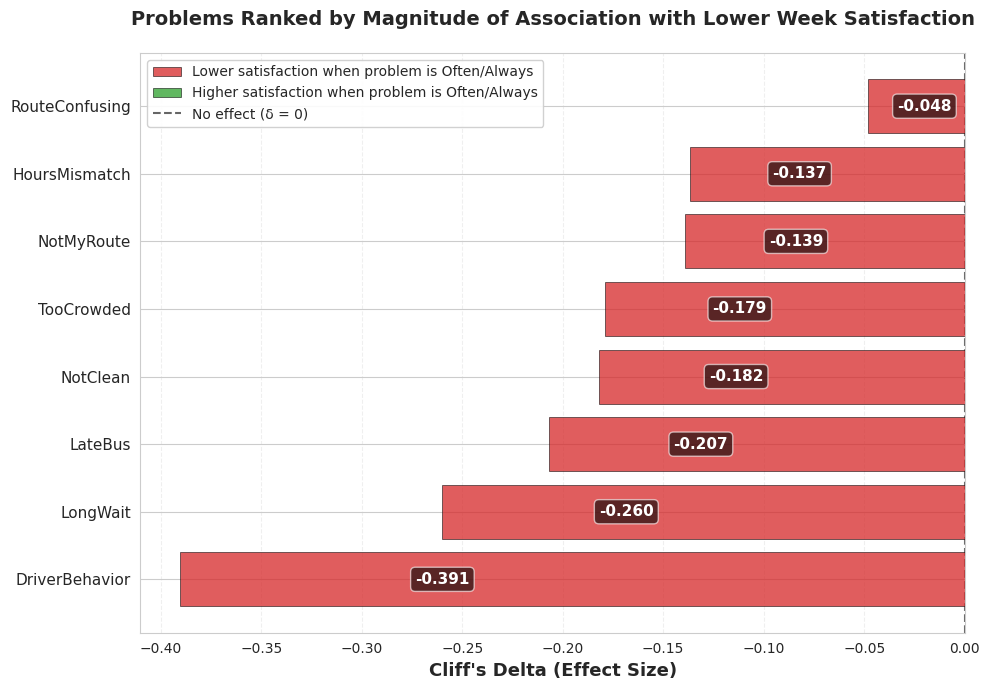

In [9]:
# ============================================================
# FIGURE 1: Effect Size Ranking (Mandatory)
# Horizontal bar chart of Cliff's Delta
# ============================================================

# Prepare data for plotting
# Sort by absolute magnitude from biggest to smallest
plot_data = effect_size_results.copy()
plot_data['Abs_Cliffs_Delta'] = plot_data['Cliffs_Delta'].abs()
plot_data = plot_data.sort_values('Abs_Cliffs_Delta', ascending=False)  # Biggest magnitude first

# Create the plot
fig, ax = plt.subplots(figsize=(10, 7))

# Colors: negative (red) = worse satisfaction, positive (green) = better
colors = ['#d62728' if d < 0 else '#2ca02c' for d in plot_data['Cliffs_Delta']]

# Horizontal bar chart (left-sided, extending from 0)
y_pos = np.arange(len(plot_data))
bars = ax.barh(y_pos, plot_data['Cliffs_Delta'], color=colors, alpha=0.75, edgecolor='black', linewidth=0.5)

# Labels and formatting
ax.set_yticks(y_pos)
ax.set_yticklabels(plot_data['Problem'].values, fontsize=11)
ax.set_xlabel("Cliff's Delta (Effect Size)", fontsize=13, fontweight='bold')
ax.set_title(
    "Problems Ranked by Magnitude of Association with Lower Week Satisfaction",
    fontsize=14, fontweight='bold', pad=20
)

# Add vertical line at 0
ax.axvline(x=0, color='black', linestyle='--', linewidth=1.5, alpha=0.6, zorder=0)

# Add grid for readability
ax.grid(axis='x', alpha=0.3, linestyle='--', zorder=0)

# Add significance stars and effect size values - INSIDE the bars for better visibility
for i, (idx, row) in enumerate(plot_data.iterrows()):
    d = row['Cliffs_Delta']
    p_holm = row['P_value_Holm']
        
    # Add value label INSIDE the bar (white text on red background)
    value_text = f"{d:.3f}"
    
    # Position text inside the bar, slightly offset from the left edge
    # For negative values, position at about 1/3 from the left end of the bar
    x_pos = d * 0.7  # 30% from the left end of the bar
    ax.text(x_pos, i, value_text, 
            va='center', ha='left', fontsize=11, fontweight='bold',
            color='white',  # White text for visibility on red bars
            bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.6, edgecolor='white', linewidth=1))

# Legend - moved to upper right corner
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#d62728', alpha=0.75, edgecolor='black', linewidth=0.5, 
          label='Lower satisfaction when problem is Often/Always'),
    Patch(facecolor='#2ca02c', alpha=0.75, edgecolor='black', linewidth=0.5, 
          label='Higher satisfaction when problem is Often/Always'),
    plt.Line2D([0], [0], color='k', linestyle='--', linewidth=1.5, alpha=0.6, 
               label='No effect (δ = 0)')
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10, framealpha=0.9)

plt.tight_layout()
plt.show()

In [10]:
# ============================================================
# 6) FINAL SUMMARY TABLE
# ============================================================

# Combine results into one summary table
summary = effect_size_results.merge(
    correlation_results[['Problem', 'Spearman_rho']], 
    on='Problem', 
    how='left'
)

# Select key columns
summary_final = summary[[
    'Problem', 
    'Rank',
    'Spearman_rho',
    'Cliffs_Delta',
    'Median_OftenAlways',
    'Median_Not',
    'Median_Diff',
    'P_value_Holm',
    'Significant',
    'N_Total'
]].copy()

summary_final = summary_final.sort_values('Rank')
summary_final['Significant'] = summary_final['Significant'].map({True: 'Yes', False: 'No'})

print("=" * 70)
print("FINAL SUMMARY: Problems Ranked by Association Strength")
print("=" * 70)
print(summary_final.round(3).to_string(index=False))

FINAL SUMMARY: Problems Ranked by Association Strength
       Problem  Rank  Spearman_rho  Cliffs_Delta  Median_OftenAlways  Median_Not  Median_Diff  P_value_Holm Significant  N_Total
DriverBehavior     1        -0.092        -0.391                 1.0         2.0         -1.0         0.004         Yes      325
      LongWait     2        -0.289        -0.260                 2.0         2.0          0.0         0.000         Yes      325
       LateBus     3        -0.135        -0.207                 1.0         2.0         -1.0         0.016         Yes      325
      NotClean     4        -0.098        -0.182                 1.0         2.0         -1.0         0.095          No      325
    TooCrowded     5        -0.150        -0.179                 2.0         2.0          0.0         0.072          No      325
    NotMyRoute     6        -0.166        -0.139                 2.0         2.0          0.0         0.095          No      325
 HoursMismatch     7        -0.141        

In [11]:
# ============================================================
# INTERPRETATION TEMPLATE
# ============================================================

print("\n" + "=" * 70)
print("INTERPRETATION TEMPLATE")
print("=" * 70)

top_problem = summary_final.iloc[0]
second_problem = summary_final.iloc[1] if len(summary_final) > 1 else None

# Build the interpretation string safely
second_problem_text = (
    f"{second_problem['Problem']} also shows a substantial association "
    f"(Cliff's delta: {second_problem['Cliffs_Delta']:.3f})."
    if second_problem is not None
    else "The second-ranked problem also shows a substantial association."
)

print(f"""
Among the evaluated service problems, {top_problem['Problem']} shows the strongest 
association with lower satisfaction, with a Cliff's delta of {top_problem['Cliffs_Delta']:.3f} 
and Spearman's rho of {top_problem['Spearman_rho']:.3f}. Students reporting 'Often/Always' 
{top_problem['Problem'].lower()} have a median satisfaction of {top_problem['Median_OftenAlways']:.1f}, 
compared to {top_problem['Median_Not']:.1f} for those who do not (difference: {top_problem['Median_Diff']:.2f}).

{second_problem_text}

These associations are descriptive and do not imply causality, but they indicate which 
bottlenecks most closely track dissatisfaction in the respondent sample. To limit false 
positives from multiple comparisons, Holm-adjusted p-values are reported.
""")


INTERPRETATION TEMPLATE

Among the evaluated service problems, DriverBehavior shows the strongest 
association with lower satisfaction, with a Cliff's delta of -0.391 
and Spearman's rho of -0.092. Students reporting 'Often/Always' 
driverbehavior have a median satisfaction of 1.0, 
compared to 2.0 for those who do not (difference: -1.00).

LongWait also shows a substantial association (Cliff's delta: -0.260).

These associations are descriptive and do not imply causality, but they indicate which 
bottlenecks most closely track dissatisfaction in the respondent sample. To limit false 
positives from multiple comparisons, Holm-adjusted p-values are reported.



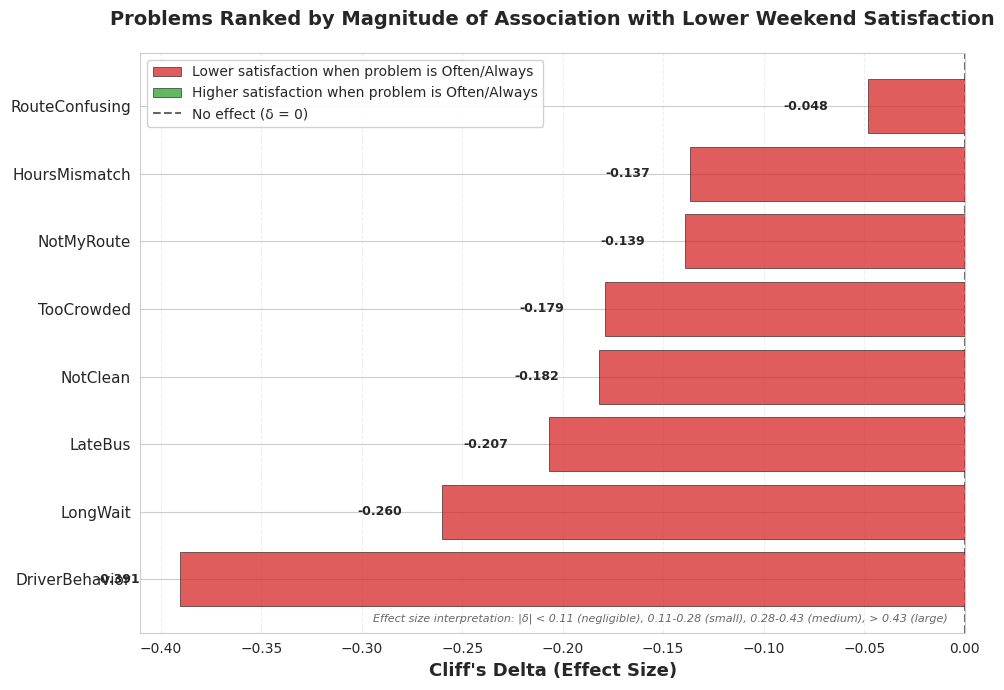

In [12]:
# ============================================================
# FIGURE 1: Effect Size Ranking (Mandatory)
# Horizontal bar chart of Cliff's Delta
# ============================================================

# Prepare data for plotting
# Sort from biggest problem (most negative) to least important (least negative)
plot_data = effect_size_results.copy()
plot_data = plot_data.sort_values('Cliffs_Delta', ascending=True)  # Most negative first (biggest problem)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 7))

# Colors: negative (red) = worse satisfaction, positive (green) = better
colors = ['#d62728' if d < 0 else '#2ca02c' for d in plot_data['Cliffs_Delta']]

# Horizontal bar chart (left-sided, extending from 0)
y_pos = np.arange(len(plot_data))
bars = ax.barh(y_pos, plot_data['Cliffs_Delta'], color=colors, alpha=0.75, edgecolor='black', linewidth=0.5)

# Labels and formatting
ax.set_yticks(y_pos)
ax.set_yticklabels(plot_data['Problem'].values, fontsize=11)
ax.set_xlabel("Cliff's Delta (Effect Size)", fontsize=13, fontweight='bold')
ax.set_title(
    "Problems Ranked by Magnitude of Association with Lower Weekend Satisfaction",
    fontsize=14, fontweight='bold', pad=20
)

# Add vertical line at 0
ax.axvline(x=0, color='black', linestyle='--', linewidth=1.5, alpha=0.6, zorder=0)

# Add grid for readability
ax.grid(axis='x', alpha=0.3, linestyle='--', zorder=0)

# Add significance stars and effect size values
for i, (idx, row) in enumerate(plot_data.iterrows()):
    d = row['Cliffs_Delta']
    p_holm = row['P_value_Holm']
    
    # Add value label on bars (left side since bars extend left)
    value_text = f"{d:.3f}"
    
    # Position text on the left side of the bar (since it's negative and extends left)
    x_pos = d - 0.02  # Slightly to the left of the bar end
    ax.text(x_pos, i, value_text, 
            va='center', ha='right', fontsize=9, fontweight='bold')

# Legend - moved to upper right corner
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#d62728', alpha=0.75, edgecolor='black', linewidth=0.5, 
          label='Lower satisfaction when problem is Often/Always'),
    Patch(facecolor='#2ca02c', alpha=0.75, edgecolor='black', linewidth=0.5, 
          label='Higher satisfaction when problem is Often/Always'),
    plt.Line2D([0], [0], color='k', linestyle='--', linewidth=1.5, alpha=0.6, 
               label='No effect (δ = 0)')
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10, framealpha=0.9)

# Add effect size interpretation guide (subtle)
ax.text(0.98, 0.02, 
        "Effect size interpretation: |δ| < 0.11 (negligible), 0.11-0.28 (small), "
        "0.28-0.43 (medium), > 0.43 (large)",
        transform=ax.transAxes, ha='right', fontsize=8, style='italic', alpha=0.7)


plt.tight_layout()
plt.show()

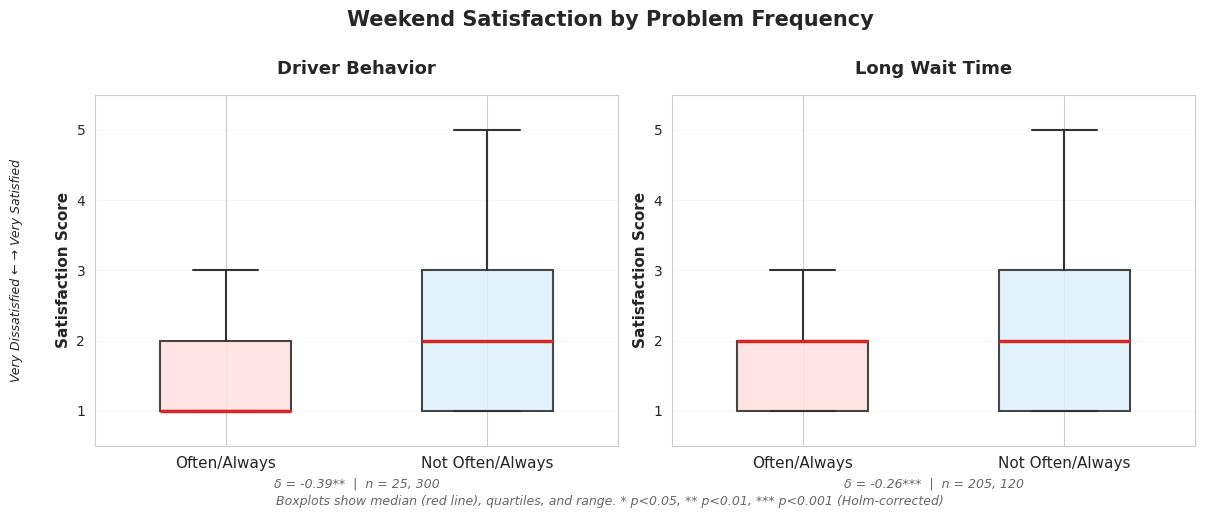

In [13]:
# ============================================================
# FIGURE 2: Satisfaction Distributions for Top 2 Problems
# Clean, professional boxplots (simplified)
# ============================================================

# Get top 2 problems by effect size
top_2_problems = effect_size_results.head(2)['Problem'].values

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(
    'Weekend Satisfaction by Problem Frequency',
    fontsize=15, fontweight='bold', y=1.0
)

# Problem display names (more readable)
problem_display_names = {
    'LongWait': 'Long Wait Time',
    'LateBus': 'Late Bus',
    'TooCrowded': 'Overcrowding',
    'NotMyRoute': 'Route Mismatch',
    'RouteConfusing': 'Confusing Route',
    'HoursMismatch': 'Hours Mismatch',
    'NotClean': 'Not Clean',
    'DriverBehavior': 'Driver Behavior'
}

for idx, problem_name in enumerate(top_2_problems):
    ax = axes[idx]
    col = f'Problem_{problem_name}'
    
    if col not in df.columns:
        continue
    
    # Prepare data
    df_temp = df[[col, primary_outcome]].copy().dropna()
    df_temp['Problem_Binary'] = (df_temp[col] >= 4).astype(int)
    
    # Get groups
    group_often_always = df_temp[df_temp['Problem_Binary'] == 1][primary_outcome]
    group_not = df_temp[df_temp['Problem_Binary'] == 0][primary_outcome]
    
    # Create clean boxplot
    bp = ax.boxplot(
        [group_often_always.values, group_not.values],
        positions=[0, 1],
        widths=0.5,
        patch_artist=True,
        showfliers=False,  # No outliers for cleaner look
        medianprops=dict(color='#d62728', linewidth=2.5),
        boxprops=dict(facecolor='white', alpha=0.9, edgecolor='#333333', linewidth=1.5),
        whiskerprops=dict(color='#333333', linewidth=1.5),
        capprops=dict(color='#333333', linewidth=1.5)
    )
    
    # Color the boxes differently
    colors_box = ['#fee2e2', '#e0f2fe']  # Light red, light blue
    for patch, color in zip(bp['boxes'], colors_box):
        patch.set_facecolor(color)
    
    # Simple formatting
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Often/Always', 'Not Often/Always'], fontsize=11)
    
    # Clean y-axis
    ax.set_ylabel('Satisfaction Score', fontsize=11, fontweight='bold')
    ax.set_ylim(0.5, 5.5)
    ax.set_yticks([1, 2, 3, 4, 5])
    ax.set_yticklabels(['1', '2', '3', '4', '5'], fontsize=10)
    
    # Add y-axis label on the left subplot only
    if idx == 0:
        ax.text(-0.15, 0.5, 'Very Dissatisfied ← → Very Satisfied', 
                transform=ax.transAxes, rotation=90, ha='center', va='center',
                fontsize=9, style='italic')
    
    # Minimal grid
    ax.grid(axis='y', alpha=0.2, linestyle='-', linewidth=0.5, zorder=0)
    ax.set_axisbelow(True)
    
    # Clean title - just problem name
    display_name = problem_display_names.get(problem_name, problem_name)
    ax.set_title(display_name, fontsize=13, fontweight='bold', pad=15)
    
    # Effect size and sample size in subtitle (subtle)
    effect_row = effect_size_results[effect_size_results['Problem'] == problem_name].iloc[0]
    cliffs_d = effect_row['Cliffs_Delta']
    p_holm = effect_row['P_value_Holm']
    star = '***' if p_holm < 0.001 else '**' if p_holm < 0.01 else '*' if p_holm < 0.05 else ''
    
    n_often = len(group_often_always)
    n_not = len(group_not)
    
    # Subtle subtitle
    ax.text(0.5, -0.12, f"δ = {cliffs_d:.2f}{star}  |  n = {n_often}, {n_not}", 
            transform=ax.transAxes, ha='center', fontsize=9, 
            style='italic', color='#666666')

# Add simple caption at bottom
fig.text(0.5, 0.01, 
         "Boxplots show median (red line), quartiles, and range. "
         "* p<0.05, ** p<0.01, *** p<0.001 (Holm-corrected)",
         ha='center', fontsize=9, style='italic', color='#666666')

plt.tight_layout()
plt.show()

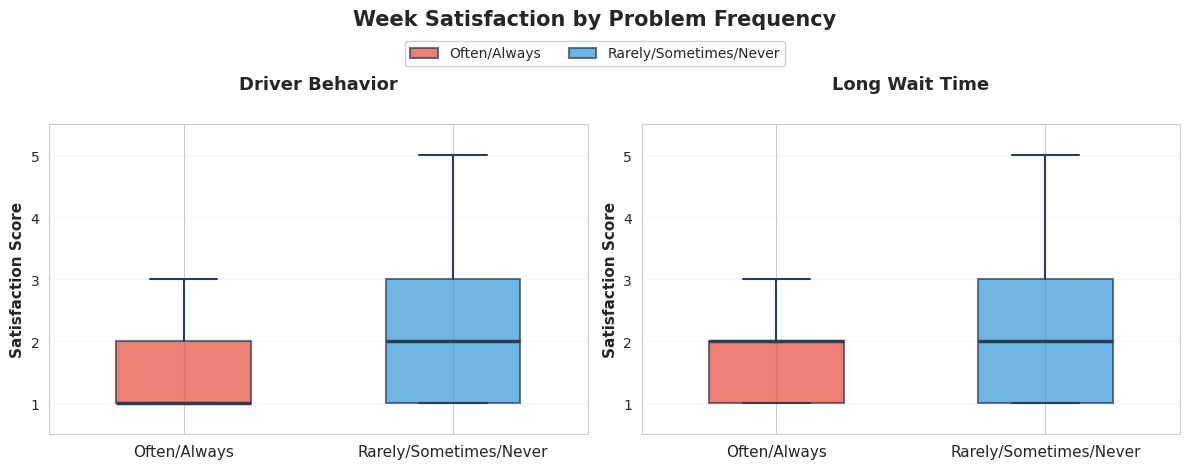

In [14]:
# ============================================================
# FIGURE 2: Satisfaction Distributions for Top 2 Problems
# Clean boxplots with color palette
# ============================================================

# Get top 2 problems by effect size
top_2_problems = effect_size_results.head(2)['Problem'].values

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(
    'Week Satisfaction by Problem Frequency',
    fontsize=15, fontweight='bold', y=0.98
)

# Problem display names (more readable)
problem_display_names = {
    'LongWait': 'Long Wait Time',
    'LateBus': 'Late Bus',
    'TooCrowded': 'Overcrowding',
    'NotMyRoute': 'Route Mismatch',
    'RouteConfusing': 'Confusing Route',
    'HoursMismatch': 'Hours Mismatch',
    'NotClean': 'Not Clean',
    'DriverBehavior': 'Driver Behavior'
}

# Color palette - professional colors for statistical plots
colors_palette = {
    'often': '#e74c3c',      # Red for "Often/Always" (problem present frequently)
    'not_often': '#3498db'   # Blue for "Rarely/Sometimes/Never" (problem less frequent)
}

for idx, problem_name in enumerate(top_2_problems):
    ax = axes[idx]
    col = f'Problem_{problem_name}'
    
    if col not in df.columns:
        continue
    
    # Prepare data
    df_temp = df[[col, primary_outcome]].copy().dropna()
    df_temp['Problem_Binary'] = (df_temp[col] >= 4).astype(int)
    
    # Get groups
    # Group 1: Often/Always (score >= 4) = problem present frequently
    # Group 0: Never/Rarely/Sometimes (score < 4) = problem less frequent
    group_often_always = df_temp[df_temp['Problem_Binary'] == 1][primary_outcome]
    group_not = df_temp[df_temp['Problem_Binary'] == 0][primary_outcome]
    
    # Create boxplot with colors
    bp = ax.boxplot(
        [group_often_always.values, group_not.values],
        positions=[0, 1],
        widths=0.5,
        patch_artist=True,
        showfliers=False,
        medianprops=dict(color='#2c3e50', linewidth=2.5),
        boxprops=dict(edgecolor='#2c3e50', linewidth=1.5),
        whiskerprops=dict(color='#2c3e50', linewidth=1.5),
        capprops=dict(color='#2c3e50', linewidth=1.5)
    )
    
    # Color the boxes with our palette
    bp['boxes'][0].set_facecolor(colors_palette['often'])
    bp['boxes'][0].set_alpha(0.7)
    bp['boxes'][1].set_facecolor(colors_palette['not_often'])
    bp['boxes'][1].set_alpha(0.7)
    
    # Clearer labels
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Often/Always', 'Rarely/Sometimes/Never'], fontsize=11, ha='center')
    
    # Clean y-axis
    ax.set_ylabel('Satisfaction Score', fontsize=11, fontweight='bold')
    ax.set_ylim(0.5, 5.5)
    ax.set_yticks([1, 2, 3, 4, 5])
    ax.set_yticklabels(['1', '2', '3', '4', '5'], fontsize=10)
    
    
    # Minimal grid
    ax.grid(axis='y', alpha=0.2, linestyle='-', linewidth=0.5, zorder=0)
    ax.set_axisbelow(True)
    
    # Clean title - just problem name (with more padding to push it down)
    display_name = problem_display_names.get(problem_name, problem_name)
    ax.set_title(display_name, fontsize=13, fontweight='bold', pad=25)  # Increased pad from 15 to 25
    
    # Effect size and sample size in subtitle (subtle)
    effect_row = effect_size_results[effect_size_results['Problem'] == problem_name].iloc[0]
    cliffs_d = effect_row['Cliffs_Delta']
    p_holm = effect_row['P_value_Holm']
    star = '***' if p_holm < 0.001 else '**' if p_holm < 0.01 else '*' if p_holm < 0.05 else ''
    
    n_often = len(group_often_always)
    n_not = len(group_not)

# Add legend with clearer labels - positioned HIGHER than subplot titles
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=colors_palette['often'], alpha=0.7, edgecolor='#2c3e50', linewidth=1.5,
          label='Often/Always'),
    Patch(facecolor=colors_palette['not_often'], alpha=0.7, edgecolor='#2c3e50', linewidth=1.5,
          label='Rarely/Sometimes/Never')
]
# Position legend HIGHER (above subplot titles) - between suptitle and subplot titles
fig.legend(handles=legend_elements, loc='upper center', ncol=2, 
           fontsize=10, framealpha=0.9, bbox_to_anchor=(0.5, 0.93))

# Adjust layout: leave space at top for legend, push subplots and their titles down
plt.tight_layout(rect=[0, 0.05, 1, 0.90])  # Top margin at 0.90 to make room
plt.subplots_adjust(top=0.75)  # Push subplots down so titles are below legend
plt.show()

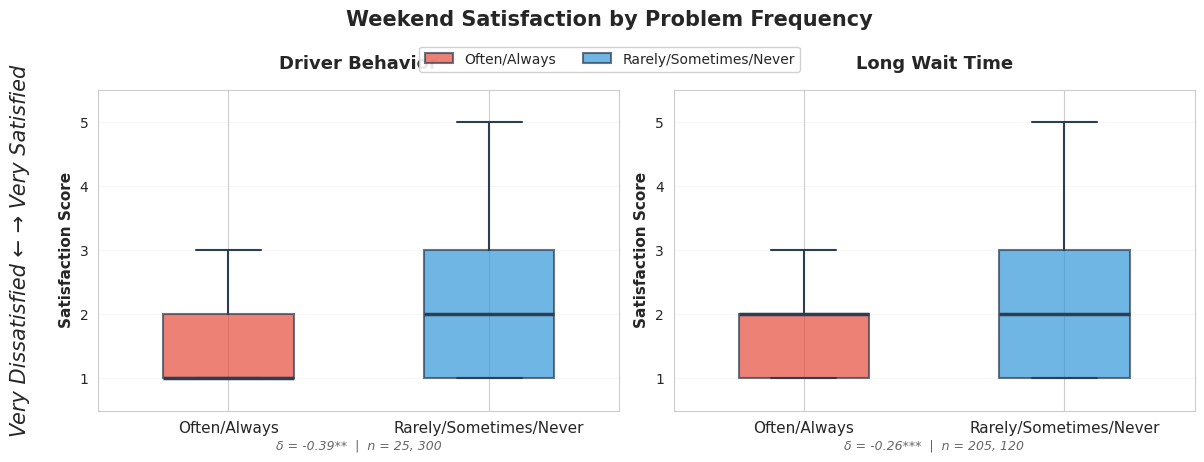

In [15]:
# ============================================================
# FIGURE 2: Satisfaction Distributions for Top 2 Problems
# Clean boxplots with color palette
# ============================================================

# Get top 2 problems by effect size
top_2_problems = effect_size_results.head(2)['Problem'].values

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(
    'Weekend Satisfaction by Problem Frequency',
    fontsize=15, fontweight='bold', y=0.98  # Slightly lower to make room
)

# Problem display names (more readable)
problem_display_names = {
    'LongWait': 'Long Wait Time',
    'LateBus': 'Late Bus',
    'TooCrowded': 'Overcrowding',
    'NotMyRoute': 'Route Mismatch',
    'RouteConfusing': 'Confusing Route',
    'HoursMismatch': 'Hours Mismatch',
    'NotClean': 'Not Clean',
    'DriverBehavior': 'Driver Behavior'
}

# Color palette - professional colors for statistical plots
colors_palette = {
    'often': '#e74c3c',      # Red for "Often/Always" (problem present frequently)
    'not_often': '#3498db'   # Blue for "Rarely/Sometimes/Never" (problem less frequent)
}

for idx, problem_name in enumerate(top_2_problems):
    ax = axes[idx]
    col = f'Problem_{problem_name}'
    
    if col not in df.columns:
        continue
    
    # Prepare data
    df_temp = df[[col, primary_outcome]].copy().dropna()
    df_temp['Problem_Binary'] = (df_temp[col] >= 4).astype(int)
    
    # Get groups
    # Group 1: Often/Always (score >= 4) = problem present frequently
    # Group 0: Never/Rarely/Sometimes (score < 4) = problem less frequent
    group_often_always = df_temp[df_temp['Problem_Binary'] == 1][primary_outcome]
    group_not = df_temp[df_temp['Problem_Binary'] == 0][primary_outcome]
    
    # Create boxplot with colors
    bp = ax.boxplot(
        [group_often_always.values, group_not.values],
        positions=[0, 1],
        widths=0.5,
        patch_artist=True,
        showfliers=False,
        medianprops=dict(color='#2c3e50', linewidth=2.5),
        boxprops=dict(edgecolor='#2c3e50', linewidth=1.5),
        whiskerprops=dict(color='#2c3e50', linewidth=1.5),
        capprops=dict(color='#2c3e50', linewidth=1.5)
    )
    
    # Color the boxes with our palette
    bp['boxes'][0].set_facecolor(colors_palette['often'])
    bp['boxes'][0].set_alpha(0.7)
    bp['boxes'][1].set_facecolor(colors_palette['not_often'])
    bp['boxes'][1].set_alpha(0.7)
    
    # Clearer labels
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Often/Always', 'Rarely/Sometimes/Never'], fontsize=11, ha='center')
    
    # Clean y-axis
    ax.set_ylabel('Satisfaction Score', fontsize=11, fontweight='bold')
    ax.set_ylim(0.5, 5.5)
    ax.set_yticks([1, 2, 3, 4, 5])
    ax.set_yticklabels(['1', '2', '3', '4', '5'], fontsize=10)
    
    # Add y-axis label on the left subplot only
    if idx == 0:
        ax.text(-0.15, 0.5, 'Very Dissatisfied ← → Very Satisfied', 
                transform=ax.transAxes, rotation=90, ha='center', va='center',
                fontsize=15, style='italic')
    
    # Minimal grid
    ax.grid(axis='y', alpha=0.2, linestyle='-', linewidth=0.5, zorder=0)
    ax.set_axisbelow(True)
    
    # Clean title - just problem name
    display_name = problem_display_names.get(problem_name, problem_name)
    ax.set_title(display_name, fontsize=13, fontweight='bold', pad=15)
    
    # Effect size and sample size in subtitle (subtle)
    effect_row = effect_size_results[effect_size_results['Problem'] == problem_name].iloc[0]
    cliffs_d = effect_row['Cliffs_Delta']
    p_holm = effect_row['P_value_Holm']
    star = '***' if p_holm < 0.001 else '**' if p_holm < 0.01 else '*' if p_holm < 0.05 else ''
    
    n_often = len(group_often_always)
    n_not = len(group_not)
    
    # Subtle subtitle
    ax.text(0.5, -0.12, f"δ = {cliffs_d:.2f}{star}  |  n = {n_often}, {n_not}", 
            transform=ax.transAxes, ha='center', fontsize=9, 
            style='italic', color='#666666')

# Add legend with clearer labels - moved to upper center
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=colors_palette['often'], alpha=0.7, edgecolor='#2c3e50', linewidth=1.5,
          label='Often/Always'),
    Patch(facecolor=colors_palette['not_often'], alpha=0.7, edgecolor='#2c3e50', linewidth=1.5,
          label='Rarely/Sometimes/Never')
]
# Position legend at the upper center, below the main title
fig.legend(handles=legend_elements, loc='upper center', ncol=2, 
           fontsize=10, framealpha=0.9, bbox_to_anchor=(0.5, 0.92))

# Adjust layout: leave more space at top for legend, push subplots down
plt.tight_layout(rect=[0, 0.05, 1, 0.85])  # Top margin at 0.85 to make room for legend
plt.subplots_adjust(top=0.82)  # Additional adjustment to push subplots down
plt.show()

